## Dependencies

In [3]:
%load_ext tensorboard

In [2]:
import os
import numpy as np
from sklearn.model_selection import KFold
from ipynb.fs.full.Dataset_Construction_Isolated import construct_dataset
import matplotlib.pyplot as plt
import matplotlib.image as plt_img

import tensorflow as tf
from tensorflow.keras import layers, models, datasets
import datetime

from zipfile import ZipFile 

2025-03-02 14:06:01.919909: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740920761.959277   12103 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740920761.971252   12103 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-02 14:06:02.024889: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## GPU Check

In [3]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Parameters

In [8]:
name = "TestCNN"
epochs = 10
steps = 50
batch = 40

## Making directory for CNN

In [5]:
try:
    os.mkdir("CNN/" + name)
except:
    pass

try:
    os.mkdir("CNN/" + name + "/Tensorboard_Data")
except:
    pass

## Load constructed dataset

In [6]:
lst = os.listdir() 
if ("mushroom_dataset_x.npy" not in lst) or ("mushroom_dataset_y.npy" not in lst):
    print("Dataset files not found, contructing...")
    dataset_x, dataset_y = construct_dataset()
else:
    print("Dataset files found, loading...")
    dataset_x = np.load("mushroom_dataset_x.npy")
    dataset_y = np.load("mushroom_dataset_y.npy")
    print("Done")

Dataset files found, loading...
Done


## CNN Training

### Create model

In [7]:
cnn = models.Sequential([
    tf.keras.Input(shape=(227, 227, 3), batch_size=batch),
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu"),
    layers.MaxPooling2D((2,2)),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dense(1, activation="sigmoid")
    ])
    
cnn.compile(optimizer="adam", loss="binary_crossentropy",  metrics=["accuracy"])
cnn.save_weights("CNN/" + name + "/default_weights.weights.h5")

I0000 00:00:1740920791.230217   12103 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5564 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6


### Train Model with n folds

In [9]:
kf = KFold(n_splits=10, shuffle=True)
kf_split = kf.split(dataset_x)
acc_array = []

for i, (train_index, val_index) in enumerate(kf_split):
    cnn.load_weights("CNN/" + name + "/default_weights.weights.h5")
    
    log_dir = "logs/fit/" + name + "-K" + str(i)
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='batch')
    history = cnn.fit(dataset_x[train_index], 
                      dataset_y[train_index], 
                      validation_data=(dataset_x[val_index], dataset_y[val_index]), 
                      epochs=epochs, 
                      steps_per_epoch=steps, 
                      callbacks=[tensorboard_callback])

    print("K = " + str(i))
    print("Accuracy  {:0.2f} %".format(history.history["accuracy"][-1] * 100))
    acc_array.append(history.history["accuracy"][-1])

2025-03-02 14:06:51.272041: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.
2025-03-02 14:06:51.938080: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10


I0000 00:00:1740920813.773787   12200 service.cc:148] XLA service 0x7fdb24004e90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740920813.774145   12200 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Compute Capability 8.6
2025-03-02 14:06:53.807974: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740920814.080923   12200 cuda_dnn.cc:529] Loaded cuDNN version 90300


 5/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.5058 - loss: 1.5495

I0000 00:00:1740920817.101610   12200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 ━━━━━━━━━━━━━━━━━━━━ 7s 47ms/step - accuracy: 0.6805 - loss: 0.9143 - val_accuracy: 0.7600 - val_loss: 0.4963
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7724 - loss: 0.4440 - val_accuracy: 0.8500 - val_loss: 0.4088
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8649 - loss: 0.3204 - val_accuracy: 0.8500 - val_loss: 0.3375
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9220 - loss: 0.2064 - val_accuracy: 0.8850 - val_loss: 0.2771
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9316 - loss: 0.1481 - val_accuracy: 0.9250 - val_loss: 0.1921
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9676 - loss: 0.1037 - val_accuracy: 0.9150 - val_loss: 0.2415
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9738 - loss: 0.0799 - val_accuracy: 0.9300 - val_loss: 0.2461
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9772 - loss: 0.0546 - val_accuracy: 0.9350 - val_loss: 0.

/home/willoghby/miniconda3/envs/tf/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 18 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
2025-03-02 14:07:11.918321: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.
2025-03-02 14:07:12.481819: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6302 - loss: 0.9563 - val_accuracy: 0.7500 - val_loss: 0.4873
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7854 - loss: 0.4620 - val_accuracy: 0.8150 - val_loss: 0.4027
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8439 - loss: 0.3298 - val_accuracy: 0.8200 - val_loss: 0.3886
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.9246 - loss: 0.2045 - val_accuracy: 0.7850 - val_loss: 0.3856
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9270 - loss: 0.1919 - val_accuracy: 0.8800 - val_loss: 0.3281
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.9564 - loss: 0.1086 - val_accuracy: 0.8700 - val_loss: 0.4013
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9710 - loss: 0.0750 - val_accuracy: 0.8700 - val_loss: 0.3072
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9781 - loss: 0.0561 - val_accuracy: 0.8900 - v

2025-03-02 14:07:28.261324: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1113026400 exceeds 10% of free system memory.


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.6717 - loss: 0.7659 - val_accuracy: 0.7400 - val_loss: 0.4907
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.7452 - loss: 0.4814 - val_accuracy: 0.8200 - val_loss: 0.3790
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.8449 - loss: 0.3463 - val_accuracy: 0.8700 - val_loss: 0.2998
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.9059 - loss: 0.2482 - val_accuracy: 0.9100 - val_loss: 0.2276
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.9400 - loss: 0.1537 - val_accuracy: 0.9350 - val_loss: 0.1661
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9543 - loss: 0.1226 - val_accuracy: 0.9250 - val_loss: 0.1941
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9602 - loss: 0.1088 - val_accuracy: 0.9400 - val_loss: 0.1410
Epoch 8/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.9748 - loss: 0.0810 - val_accuracy: 0.9550 - v

### Find best K-group and average

In [25]:
max_acc = max(acc_array)
acc_array.index(max_acc)
avg_acc = sum(acc_array) / len(acc_array)

print("Average accuracy = {:0.2f} %".format(avg_acc * 100))
print("K group with best accuracy = " + str(acc_array.index(max_acc)))
print("Accuracy = {:0.2f} %".format(max_acc * 100))

Average accuracy = 99.22 %
K group with best accuracy = 3
Accuracy = 99.72 %


## Open Tensorboard

In [4]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

## CNN Evaluation

### Load final dataset

In [26]:
if "FinalTrainTestSet" not in os.listdir():
        print("Unzipping final dataset...")
        with ZipFile("FinalTrainTestSet.zip", 'r') as zObject: 
            zObject.extractall(path="FinalTrainTestSet")
        print("Done")
        
print("Loading train_x...")
ftrain_x = np.load("FinalTrainTestSet/train_x.npy")
print("Done")

print("Loading train_y...")
ftrain_y = np.load("FinalTrainTestSet/train_y.npy")
print("Done")

print("Loading test_x...")
ftest_x = np.load("FinalTrainTestSet/test_x.npy")
print("Done")

print("Loading test_y...")
ftest_y = np.load("FinalTrainTestSet/test_y.npy")
print("Done")

Loading train_x...
Done
Loading train_y...
Done
Loading test_x...
Done
Loading test_y...
Done


## Train model

In [1]:
cnn.load_weights("CNN/" + name + "/default_weights.weights.h5")

log_dir = "logs/fit/" + name + "-Final"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, update_freq='epoch')

cnn.fit(ftrain_x, ftrain_y, epochs=epochs, steps_per_epoch=steps, callbacks=[tensorboard_callback])

#cnn.save("CNN/" + name + "/" + name + ".keras")

NameError: name 'cnn' is not defined

## Open Tensorboard for train time

In [2]:
%tensorboard --logdir="logs/" --host=127.0.0.1 

UsageError: Line magic function `%tensorboard` not found.


## Generate prediction set

In [28]:
pred_y = np.empty([200, 1])
meta = np.empty([1, 227, 227, 3])

for i in range(0, ftest_x.shape[0]):
    meta[0] = ftest_x[i]
    pred_value = cnn.predict(meta, verbose=0)[0][0]
    
    if pred_value > 0.5:
        pred = 1
    else:
        pred = 0
        
    pred_y[i] = pred

## Graph confusion matrix

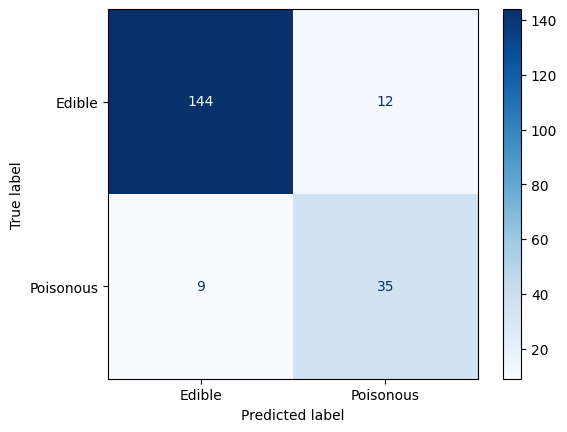

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

cm = confusion_matrix(ftest_y, pred_y)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=["Edible", "Poisonous"])
disp.plot(cmap=plt.cm.Blues).figure_.savefig("CNN/" + name + "/" + name + "_ConfustionMatrix.svg")

## CNN Metrics

In [30]:
tp = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tn = cm[1][1]

accuracy = (tp + tn) / (tp + tn + fn + fp)
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (precision *  recall) / (precision + recall)
f1 *= 2

print(name + ":")
print("Accuracy  {:0.2f} %".format(accuracy * 100))
print("Precision {:0.2f} %".format(precision * 100))
print("Recall    {:0.2f} %".format(recall * 100))
print("F1        {:0.2f} %".format(f1 * 100))

TestCNN:
Accuracy  89.50 %
Precision 92.31 %
Recall    94.12 %
F1        93.20 %
